## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

An AB test was conducted to test the performance of an old website page compared to a newly developed website page using bootstrapping for hypothesis testing.


<a id='probability'></a>
#### Part I - Probability

Import the libraries

In [68]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Read in the dataset

In [69]:
df=pd.read_csv('ab_data.csv')

In [70]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset.

In [71]:
df.shape[0]

294478

The number of unique users in the dataset.

In [72]:
df.user_id.nunique()

290584

The proportion of users converted.

In [73]:
(df.converted==1).mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [74]:
#count no of rows where treatment do not align with new page or control group do not align with old page
non_align_count=df.query('(group == "treatment" and landing_page !="new_page") or (group == "control" and landing_page !="old_page") ').count()[0]
non_align_count

3893

Check for missing values

In [75]:
df.isnull().values.any()

False

In [76]:
#Creating new dataframe by removing non aligning rows from df
df2=df.query('(group == "treatment" and landing_page =="new_page") or (group == "control" and landing_page =="old_page") ')

In [77]:
#No of rows in new dataframe
df2.shape[0]

290585

In [78]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Identify unique users for new df

In [79]:
df2.user_id.nunique()

290584

In [80]:
#Check for duplicate user ids
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Row information for the repeat **user_id** 

In [81]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [82]:
# Drop duplicate user
df2=df2.drop_duplicates(['user_id'])

In [83]:
# Check if one of the duplicate user is removed 
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [84]:
#convert timestamp column to datetime object
df2.timestamp=pd.to_datetime(df2.timestamp)

Probability of an individual converting regardless of the page they receive

In [19]:
# Probability of converting
(df2.converted==1).mean()

0.11959708724499628

In [20]:
# Get dataframe with all records from control group
control_df=df2.query('group=="control"')

# Probability of control group converting
p_old_converted=(control_df['converted']==1).mean()

# Display 
p_old_converted

0.1203863045004612

In [21]:
# Get dataframe with all records from treatment group
treatment_df=df2.query('group=="treatment"')

# Probability of treatment group converting
p_new_converted=(treatment_df['converted']==1).mean()

# Display 
p_new_converted

0.11880806551510564

In [22]:
# Probability an individual recieved new page
(df2.landing_page=="new_page").mean()

0.5000619442226688

In [23]:
# Compute the observed difference in convertions
obs_diff=p_new_converted-p_old_converted

# Display observed difference
obs_diff

-0.0015782389853555567

**The probability of conversion for control group is slightly greater than that for treatment group.However the difference is very small(0.2%).Also the probabality of landing in new page is 50% which means an individual is equally likely to land in either pages.Since the diffrence in probability is not significant, we can say that that there is no evidence of one page leading to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test


#### Null Hypothesis
$$H_0: p_{new} - p_{old} \leq 0$$
**i.e. The null hypothesis is that the difference between the population conversion rate of users given the new page and the old page is equal to or less than zero (population conversion rate of users for old page is better or equal to new page).**

#### Alternative Hypothesis
$$H_1: p_{new} - p_{old}\gt 0$$
**i.e. The alternative  hypothesis is that the difference between the population conversion rate of users given the new page and the old page is greater than zero (population conversion rate of users for new page is better).**


**Since we assume $p_{new}$ equal to converted rate regardless of page, which is equal to 0.1196, therefore**


$p_{new}$=0.1196

In [25]:
p_new=0.1196

**Under the null hypothesis, $p_{old}$ =$p_{new}$, therefore**

$p_{old}$=0.1196


In [26]:
p_old=0.1196

In [27]:
#Count number of tests with new page and old page
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

**The number of tests with new page,  $n_{new}$ is 145310**


**The number of tests with old page,  $n_{old}$ is 145274**

In [28]:
n_new,n_old=df2['landing_page'].value_counts()

Simulate the conversion rate for the new page

In [29]:
#Simulate n_new tests with p=p_new
new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new],replace=True)

Simulate the conversion rate for the old page

In [30]:
#Simulate n_old tests with p=p_old
old_page_converted=np.random.choice([1,0],size=n_old,p=[p_old,1-p_old],replace=True)

Find the difference in the conversion rate

In [31]:
#Difference in proportions for simulated values
new_page_converted.mean()-old_page_converted.mean()


-0.0002980549531405585

Run 10,000 simulations

In [32]:
p_diffs=[]
for _ in range(10000):
    bootsamp_new=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new],replace=True)
    bootsamp_old=np.random.choice([1,0],size=n_old,p=[p_old,1-p_old],replace=True)
    p_diffs.append(bootsamp_new.mean()-bootsamp_old.mean())

In [33]:
p_diffs=np.array(p_diffs)

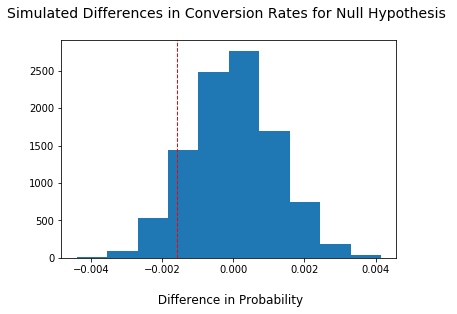

In [85]:
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(x=obs_diff, color='r', linestyle='dashed', linewidth=1);

Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [35]:
(p_diffs>obs_diff).mean()

0.9062


### Results: 

- The p-value calculated is 0.9062.

- A large p-value of 0.9 means that its very likely our observed statistic came from a population where the null hypothesis is true.

- Based on the p-value obtained from given sample and type 1 error rate of 5% we can say that,since p-value > 0.05 we do not have statistically significant evidence that population proportions for new pages is better than old pages.Therefore we fail to reject the null hypothesis.



### Comparison to built in t-test

Calculate number of rows for old and new

In [36]:
import statsmodels.api as sm

convert_old = control_df[control_df.converted==1].count()[0]
convert_new = treatment_df[treatment_df.converted==1].count()[0]

print("convert_old:", convert_old, 
      "\nconvert_new:", convert_new,
      "\nn_old:", n_old,
      "\nn_new:", n_new)

C:\Users\Aks\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


convert_old: 17489 
convert_new: 17264 
n_old: 145274 
n_new: 145310


In [37]:
import statsmodels.api as sm
#since alternative is new_page > old_page,we set alternative='larger'
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old],alternative='larger')

In [38]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [39]:
from scipy.stats import norm
# Tells us how significant our z-score is
norm.cdf(z_score)

0.09494168724097551

In [40]:
# Tells us what our critical value at 95% confidence is
norm.ppf(1-(0.05))

1.6448536269514722

<a id='regression'></a>
### Part III - A regression approach



#### Logistic Regression

Create dummy variables and add an intercept

In [41]:
import statsmodels.api as sm
#make a copy of dataframe df2
df_rm=df2

#Adding intercept column
df_rm['intercept']=1


In [42]:
#creating dummy variable columns for landing page
df_rm[['ab_page','old_page']]=pd.get_dummies(df['landing_page'])

#drop one of the dummy columns in order to make your matrices full rank
df_rm.drop('old_page',axis=1,inplace=True)

In [43]:
#confirm the changes
df_rm.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [44]:
# Set up logistic regression
log_rm=sm.Logit(df_rm['converted'],df_rm[['intercept','ab_page']])
results=log_rm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-09-27 12:28 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [45]:
#exponentiate the co-efficients to interpret the results
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [46]:
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

- From the model summary,we can say that if an individual used a old page ,they are 1.015 times more likely to be converted than if they used the new page,holding all other variables constant.Thus we see that odds are almost equal.

#### Observations
- p-value associated with ab_page(0.19) suggests that ab_page is not statistically significant in predicting whether or not an individual converts.


- The p-value from regression model is different than the one computed in Part 2 which is 0.9.The reason for the difference is due to difference in assumptions in the hypothesis.In the case of part 2,we are assuming under alternative hypothesis that new page has better conversions and hence one-tailed test. However, in part 3, in the case of  regression test is we are not concerned with which page has a higher conversion rate.We only check whether the new page has any effect on convertion or not and hence a two-tailed test.

### Adding additional variables to the model

To check whether the user country has any impact on conversion,we read in the **countries.csv** dataset and merge it with original data.

In [49]:
countries_df=pd.read_csv('countries.csv')

In [50]:
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
countries_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [52]:
#merge the countries dataframe with original data
df_rm2 = df_rm.merge(countries_df, on='user_id')

In [53]:
df_rm2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [54]:
#get dummy variables for countries
df_rm2[['country_CA','country_UK','country_US']]=pd.get_dummies(df_rm2['country'])

In [55]:
df_rm2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,country_CA,country_UK,country_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [56]:
#drop one of the columns
df_rm2.drop('country_US',axis=1,inplace=True)

In [57]:
#set up logistic regression
log_rm2=sm.Logit(df_rm2['converted'],df_rm2[['intercept','ab_page','country_UK','country_CA']])
results2=log_rm2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-09-27 12:28 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
country_UK    0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
country_CA   -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

In [58]:
np.exp(results2.params)

intercept     0.136795
ab_page       0.985168
country_UK    1.009932
country_CA    0.960062
dtype: float64

In [59]:
1/np.exp(results2.params)

intercept     7.310207
ab_page       1.015056
country_UK    0.990165
country_CA    1.041599
dtype: float64

#### Observations
- p-value associated with country_UK and country_CA suggests that variable country is not statistically significant in predicting whether or not an individual converts.


- From the model summary,we can say that if an individual is from USA,they are 1.009 times less likely to be converted than a individual from UK and 1.04 times more likely to be converted than a individual from Canada,holding all other variables constant.Thus we see that odds are almost equal.

### Check for an interaction between country and page

In [61]:
df_rm2['CA_page'] = df_rm2['country_CA'] * df_rm2['ab_page']
df_rm2['UK_page'] = df_rm2['country_UK'] * df_rm2['ab_page']
df_rm2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,country_CA,country_UK,CA_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,0,0


In [65]:
log_rm3= sm.Logit(df_rm2['converted'], df_rm2[['intercept', 'ab_page', 'country_CA', 'country_UK', 'CA_page', 'UK_page']])
results3 = log_rm3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-09-27 12:35 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
country_CA   -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
country_UK   -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

#### Observations
None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

### Influences associated with time(day of the week) on conversion

Consider day of the week as a factor influencing convertion.In order to do this, I first check if both tests were done over similiar time periods and how long the tests ran.

In [86]:
#Check the timestamp for control group users
control_df.timestamp.min(),control_df.timestamp.max()

(Timestamp('2017-01-02 13:42:15.234051'),
 Timestamp('2017-01-24 13:41:54.460509'))

In [87]:
#Check the timestamp for treatment group users
treatment_df.timestamp.min(),treatment_df.timestamp.max()

(Timestamp('2017-01-02 13:42:05.378582'),
 Timestamp('2017-01-24 13:41:44.097174'))

- Since we have 3 full business cycles(21 days), adding weekday/weekend variable can give us a better insight on conversion.Other factor that may influence conversion is duration of time a user spents on a given page.**

In [88]:
#Extract dayofweek from timestamp
df_rm['day']=df_rm['timestamp'].dt.dayofweek

In [89]:
#create 2 dummy variables(1 for weekday and 0 for weekend)
df_rm[['weekend','weekday']]=pd.get_dummies(df_rm['day']<5)
#drop weekend column
df_rm.drop('weekend',axis=1,inplace=True)

In [90]:
df_rm.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,day,weekday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,5,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,3,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,6,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,5,0


In [91]:
#set up logistic regression
log_rm4=sm.Logit(df_rm['converted'],df_rm[['intercept','ab_page','weekday']])
results4=log_rm4.fit()
results4.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-09-27 13:23 AIC:              212782.3478
No. Observations:   290584           BIC:              212814.0868
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9883    0.0123  -161.5755  0.0000  -2.0124  -1.9642
ab_page      -0.0150    0.0114    -1.3108  0.1899  -0.0374   0.0074
weekday      -0.0006    0.0128    -0.0488  0.9610  -0.0257   0.0245
==================================================================

"""

In [93]:
np.exp(results4.params)

intercept    0.136925
ab_page      0.985124
weekday      0.999374
dtype: float64

In [94]:
1/np.exp(results4.params)

intercept    7.303275
ab_page      1.015101
weekday      1.000626
dtype: float64

#### Observations
- p-value associated with weekday suggests that the variable weekday is not statistically significant in predicting whether or not an individual converts.


- From the model summary,we can say that if an individual is using the webpage on weekend,they are 1.0006 times more likely to be converted than if they use the webpage on weekday, holding all other variables constant.Hence odds of convertion are almost the same for weekdays and weekends.

## Conclusion

- Using different statistical analysis(probability,hypothesis testing with sampling distribution and regression models) for A/B test results we can conclude that there is no significant evidence that new version of the page would result in more convertions.


- We found very small difference in convertion rate for new and old page,with old page doing slightly better.


- The sample size for the test is around 290k which seems to be large enough to make a prediction.The test conditions were fairly good as well, users had a roughly 50% chance to recieve the new and old pages.Also the duration of the test is 3 weeks which is long enough time for a typical A/B test and also it was enough to generate sufficient traffic to give an estimate.


- It was also found that factors like countries or day of the week had no impact on conversion rates.


- Change aversion, test span durations and other potentially influencing factors are not accounted for. So, we cannot state with certainty that one page leads to more conversions. This is even more important due to almost similar perforamnce of both pages.


- We also need to consider practical significance while implementing changes like cost of building new version versus how much more convertions would lead to profit.


- I would recommend that the e-commerce company improve their website before trying again.


